Average box office gross: $ 128887824.04878049
Average gross in sales of video games: $ 2149577095.0
Number of games with gross sales over 3 billion EUR: 8
Video Game inspired movies with a RT score >50: 5


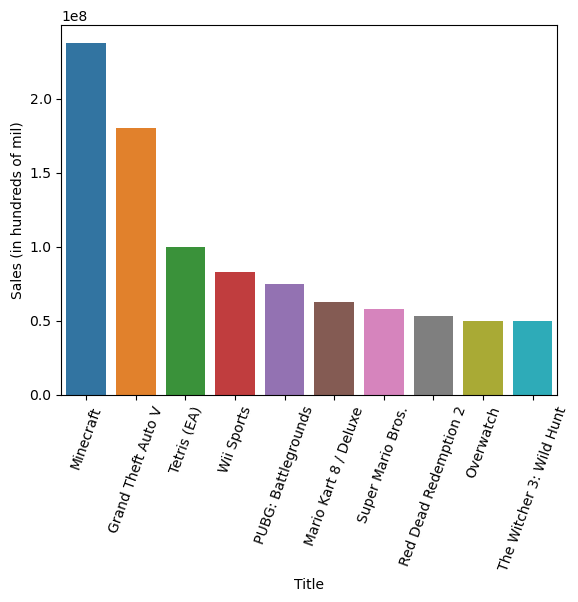

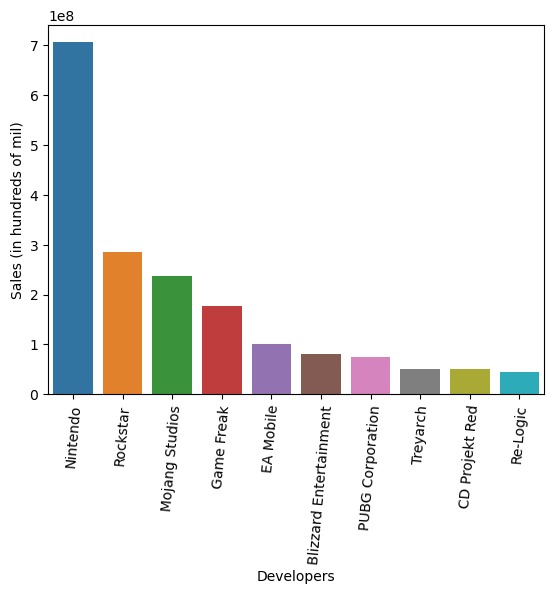

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as r
from bs4 import BeautifulSoup
from io import StringIO

#Importing, cleaning, sorting and indexing data

#web scraping wikipedia page for highest selling video games
url = 'https://en.wikipedia.org/wiki/List_of_best-selling_video_games'
unparsed_wiki = r.get(url)

#parsing data into a beautifulsoup object
soup = BeautifulSoup(unparsed_wiki.text, 'html.parser')
parsed_wiki = soup.find('table',{'class':"wikitable"})

#converting parsed data into a dataframe
videogame_sales = pd.read_html(str(parsed_wiki))
vg_sales = pd.DataFrame(videogame_sales[0])

#dropping 'Ref' column. inplace = True so to not create new dataframe
vg_sales.drop(columns = ['Ref'], inplace = True)

#renaming columns to remove superfluous syntax, setting index and replacing value
vg_sales.set_index("Title", inplace = True)
vg_sales.rename(
    columns={
        "Platform(s)": "Platform",
        "Initial release date": "date",
        "Developer(s)[b]": "Developer",
        "Publisher(s)[b]": "Publisher"
    },
    inplace=True
)
#consolidating Developer value
mapping = {
    'Nintendo R&D1': 'Nintendo',
    'Nintendo EAD': 'Nintendo',
    'Nintendo EPD': 'Nintendo',
    'Nintendo R&D4': 'Nintendo',
    'Nintendo EAD / Nintendo EPD (Deluxe)': 'Nintendo' 
}
vg_sales['Developer'].replace(mapping, inplace = True)

mapping2 = {
    'Rockstar North': 'Rockstar',
    'Rockstar Studios': 'Rockstar',
}
vg_sales['Developer'].replace(mapping2, inplace = True)

vg_sales.loc['Minecraft', 'date'] = ('November 18, 2011')

#importing data from two .csv (video game inspired movies)
vg_movies_csv1_url = "https://raw.githubusercontent.com/jimmyneutrone/-UCDPA_jaimepira-/wip/video_game_films1.csv"
response1 = r.get(vg_movies_csv1_url)
data1 = StringIO(response1.text)
video_game_movies = pd.read_csv(data1)

vg_movies_csv2_url = "https://raw.githubusercontent.com/jimmyneutrone/-UCDPA_jaimepira-/wip/video_game_films2.csv"
response2 = r.get(vg_movies_csv2_url)
data2 = StringIO(response2.text)
highest_gross_movies = pd.read_csv(data2)


#merging the two df to create a more complete list of movies inspired by video games
vg_movies = pd.merge(video_game_movies, highest_gross_movies, how = 'outer')
#removing duplicates and irrelevant data columns
vg_movies.drop_duplicates(subset = "Title", inplace = True)
vg_movies.drop(columns = ['Rank', 'Peak', 'gross', 'Date', 'Format'], inplace = True)

#sorting vg_movies by box office returns and indexing by movie in descending order
vg_movies.sort_values("Worldwide box office", ascending = False, inplace = True)
vg_movies.set_index("Title", inplace = True)


#Statistical analysis of dataframes


# Statistical analysis of movies gross
avg_gross_vgmovies = vg_movies['Worldwide box office'].mean()
print("Average box office gross: $", avg_gross_vgmovies)

# Statistical analysis of video games gross
avg_gross_vg = (vg_sales['Sales'] * 50).mean()
print("Average gross in sales of video games: $", avg_gross_vg)

#How many games have grossed more than 3billion?
count = 0 

for game_name, sold_copies in vg_sales['Sales'].items():
    gross_sales = sold_copies * 59 
    if gross_sales > 3_000_000_000:  
        count += 1

print("Number of games with gross sales over 3 billion EUR:", count)

# How many movies have a Rotten Tomatoes score over 50?
count = 0

for movie, rotten_tomatoes_score in vg_movies['Rotten Tomatoes'].items():
    if rotten_tomatoes_score > 50:  
        count += 1
print("Video Game inspired movies with a RT score >50:", count)



#Subsetting and plotting data
sales_by_dev = vg_sales.groupby('Developer')['Sales'].sum().reset_index()
sales_by_dev.sort_values(by='Sales', ascending=False, inplace = True)
top10_sales_by_dev = sales_by_dev[:10]
top10_vgmovies = vg_movies[:10]
top10_vgsales = vg_sales[:10]

#plotting sales by video game
sns.barplot(x=top10_vgsales.index, y='Sales', data = top10_vgsales)
plt.xlabel('Title')
plt.ylabel('Sales (in hundreds of mil)')

plt.xticks(rotation=70) 
plt.show()

#plotting sales by developer
sns.barplot(x='Developer', y='Sales', data = top10_sales_by_dev)
plt.xlabel('Developers')
plt.ylabel('Sales (in hundreds of mil)')
plt.xticks(rotation=85) 
plt.show()


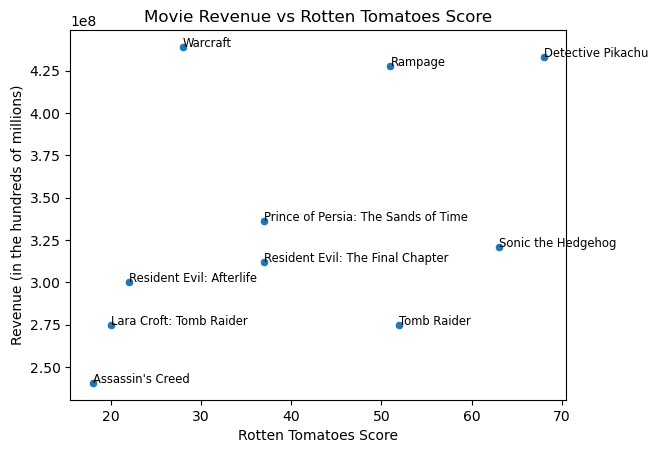

In [6]:
#Subsetting by success metric
gross_vgmovies = top10_vgmovies['Worldwide box office']
rotten_tomatoes_score = top10_vgmovies['Rotten Tomatoes']

scatter_plot = sns.scatterplot(x=rotten_tomatoes_score, y=gross_vgmovies)

#Plotting most successful movies based on revenue and Rotten Tomatoes score.
for i, label in enumerate(top10_vgmovies.index):
    scatter_plot.text(rotten_tomatoes_score[i], gross_vgmovies[i], label, 
                      horizontalalignment='left', size='small', color='black'
)

plt.xlabel('Rotten Tomatoes Score')
plt.ylabel('Revenue (in the hundreds of millions)')
plt.title('Movie Revenue vs Rotten Tomatoes Score')

plt.show()


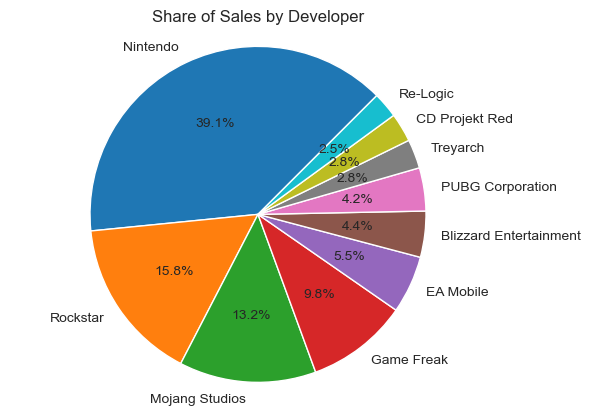

In [47]:

#Share of market by Developer (top 10)
top10_aggregated_sales = vg_sales.groupby('Developer')['Sales'].sum().reset_index().nlargest(10, 'Sales')
total_sales = top10_aggregated_sales['Sales'].sum()
top10_aggregated_sales['Percentage'] = (top10_aggregated_sales['Sales'] / total_sales) * 100

plt.pie(top10_aggregated_sales['Percentage'], labels=top10_aggregated_sales['Developer'], autopct='%1.1f%%', startangle=45)

plt.title('Share of Sales by Developer')
plt.axis('equal')
plt.show()


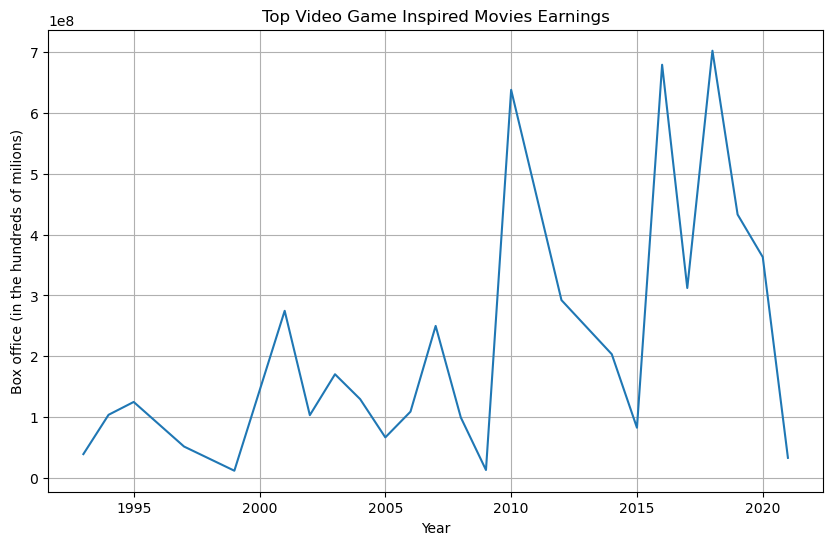

In [10]:
#The top10 video game inspired movies market trends over time
vg_movies['Release date'] = pd.to_datetime(vg_movies['Release date'])
yearly_sales = vg_movies.groupby(vg_movies['Release date'].dt.year)['Worldwide box office'].sum()

plt.figure(figsize=(10, 6))  
sns.lineplot(x=yearly_sales.index, y=yearly_sales.values)
plt.title('Top Video Game Inspired Movies Earnings')
plt.xlabel('Year')
plt.ylabel('Box office (in the hundreds of milions)')
plt.grid(True)
plt.show()

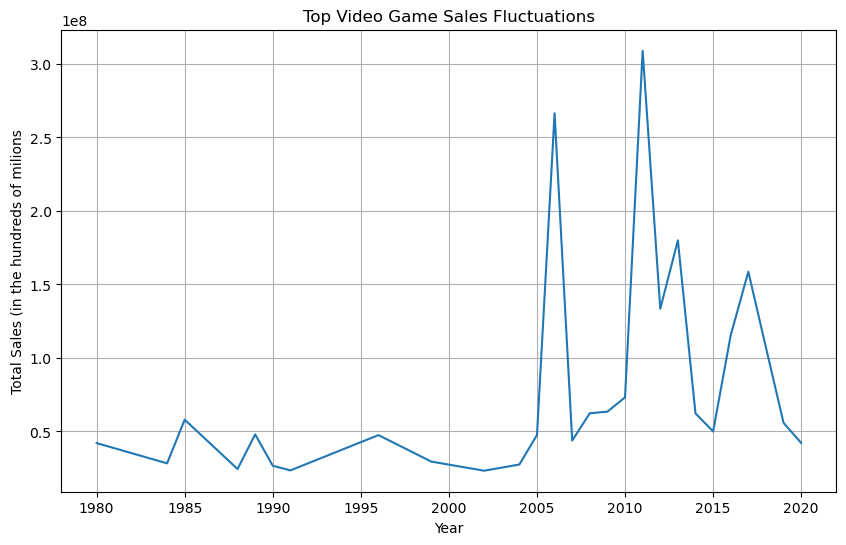

In [12]:
#The top10 video game market trends over time
vg_sales['date'] = pd.to_datetime(vg_sales['date'])
yearly_sales = vg_sales.groupby(vg_sales['date'].dt.year)['Sales'].sum()

plt.figure(figsize=(10, 6))  
sns.lineplot(x=yearly_sales.index, y=yearly_sales.values)
plt.title('Top Video Game Sales Fluctuations')
plt.xlabel('Year')
plt.ylabel('Total Sales (in the hundreds of milions')
plt.grid(True)
plt.show()
